# Point sources in heterogeneous media

## Setup the problem

In [1]:
from jax import numpy as jnp
import numpy as np

In [2]:
# Defining geometry
from jwave.geometry import kGrid, TimeAxis, Medium, Sources

N = (512, 512)
dx = (0.5, 0.5)

cfl = 0.1

grid = kGrid.make_grid(N, dx)

In [3]:
# Physical properties
sound_speed = jnp.ones(N) 
sound_speed = sound_speed.at[100:200,200:300].set(2.)
sound_speed = sound_speed.at[150:250,250:450].set(1.5)
sound_speed = sound_speed.at[350:400,150:350].set(1.3)

# Physical properties
medium = Medium(
    sound_speed=sound_speed,
    density=jnp.ones(N),
    attenuation=0.0,
    pml_size=20
)

time_array = TimeAxis.from_kgrid(grid, medium, cfl=cfl, t_end=200.)

In [4]:
# define a source point
from jwave.signal_processing import apply_ramp

source_freq = 0.1 
source_mag = 5

def gaussian_window(signal, time, mu, sigma):
    return signal*jnp.exp(
        -(t-mu)**2/sigma**2
    )

t = jnp.arange(0, time_array.t_end, time_array.dt)
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
s1 = gaussian_window(
    apply_ramp(s1, time_array.dt, source_freq),
    t,
    50,
    10
)
s2 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
s2 = gaussian_window(
    apply_ramp(s2, time_array.dt, source_freq),
    t,
    80,
    15
)

source_signals = jnp.stack([s1,s2])
source_positions = ([150, 450], [64, 340])

sources = Sources(positions=source_positions, signals=source_signals)

Let's look at the problem setup

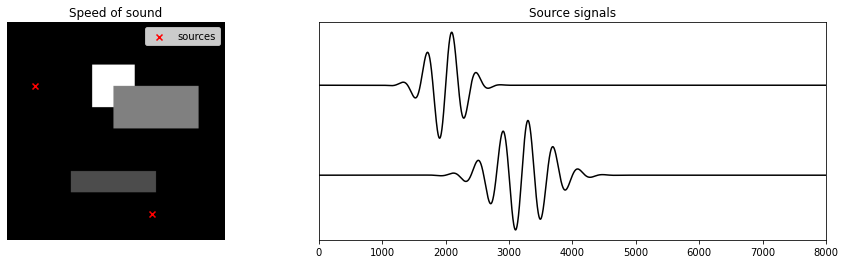

In [5]:
# Show simulation setup
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,4), gridspec_kw={'width_ratios': [1, 2]})

ax[0].imshow(medium.sound_speed, cmap="gray")
ax[0].scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
ax[0].legend()
ax[0].set_title("Speed of sound")
ax[0].axis("off")

ax[1].plot(s1+4, label="Source 1", c='k')
ax[1].plot(s2-4, label="Source 2", c='k')
ax[1].set_title("Source signals")
ax[1].set_xlim([0,8000])
ax[1].get_yaxis().set_visible(False)

## Run the simulation

In [6]:
# Run simulation
from jwave.physics import simulate_wave_propagation

output_taxis = jnp.array([0, 200.])
fields = simulate_wave_propagation(grid, medium, time_array, sources, backprop=False, output_t_axis=output_taxis)
u = fields[0]
p = jnp.sum(fields[1],1)*(medium.sound_speed**2)

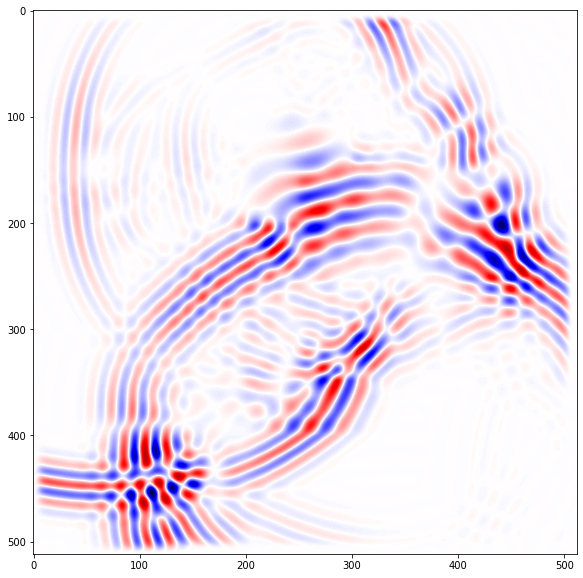

In [7]:
plt.figure(figsize=(10,10))
maxval = jnp.amax(jnp.abs(p[-1]))
plt.imshow(p[-1], cmap="seismic", vmin=-maxval, vmax=maxval)